In [1]:
import time

from tqdm import tqdm
import os
import time

import numpy as np

import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Dropout

from skimage.transform import resize
from skimage import exposure
import cv2 as cv

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

from keras.models import Model, load_model




**A function to Read .nii images using nibabel**

In [2]:
def read_image(path):
    image = nib.load(path)
    image = (image.dataobj)
    return np.asarray(image)


**Read sample image&mask**

In [3]:
# 341
case = '001'
case_path = f'../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}'

img = np.zeros((128, 128, 155))
img = np.asarray(tf.image.resize(read_image(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')), (128, 128)))


path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')
vol=read_image(path);
X = np.empty((60, 240, 240))
Y = np.zeros((60, 128, 128, 4))

for i in range(60):    
    X[i] = vol[:,:, i+34]
    
X[X==4] = 3
mask = tf.one_hot(X, 4)
Y = tf.image.resize(mask, (128, 128))
Y = np.asarray(Y, dtype = int)
print(Y.dtype)

int64


**Display t1ce slice and it's mask + processed mask**

<Figure size 432x288 with 0 Axes>

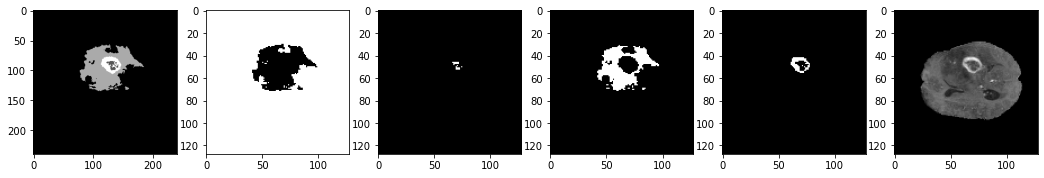

In [4]:
plt.figure()
f, axarr = plt.subplots(1,6, figsize = (18, 50)) 
s = 41
# img = np.power(img, 2)
img = img/np.max(img)

axarr[0].imshow(X[s], cmap ="gray")
axarr[1].imshow(Y[s,:,:,0], cmap="gray")
axarr[2].imshow(Y[s,:,:,1], cmap="gray")
axarr[3].imshow(Y[s,:,:,2], cmap="gray")
axarr[4].imshow(Y[s,:,:,3], cmap="gray")
axarr[5].imshow(img[:,:,s+34], cmap="gray")





In [5]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss

    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [6]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient

    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

**building Unet**

**main source: https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a **

In [7]:

# Build U-Net model
dropout=0.2
hn = 'he_normal'
def unet():
    
    inputs = Input((128, 128, 2)) 
    
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    model = Model(inputs = inputs, outputs = conv10)

    return model

K.clear_session()

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Prepare image paths to feed DataGenerator function**

In [8]:
train_set_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_IDs = next(os.walk(train_set_path, topdown=True))[1][:350]
val_IDs = next(os.walk(train_set_path, topdown=True))[1][350:370]

val_IDs.remove('BraTS20_Training_355')

**How to use dataGenerator: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly**

Here we train (the middle 100 slice of each volume) per epoch
So, Batch size=1 means batch size = 100 slice

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, spatient_IDs, dim=(128,128), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = spatient_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*100, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*100, 240, 240))
        Y = np.zeros((self.batch_size*100, *self.dim, 4))


        
        # Generate data
        # for i, ID in enumerate(Batch_ids):
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_set_path, i)

            vol_path = os.path.join(case_path, f'{i}_flair.nii');
            flair =read_image(vol_path)      

            vol_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce =read_image(vol_path)
            
            vol_path = os.path.join(case_path, f'{i}_seg.nii');
            seg =read_image(vol_path)
        
            for j in range(100):
                 X[j +100*c,:,:,0] = cv.resize(flair[:,:,j+22], (128, 128));
                 X[j +100*c,:,:,1] = cv.resize(ce[:,:,j+22], (128, 128));

                 y[j +100*c] = seg[:,:,j+22];
                    
            #=============Preprocess masks===========
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (128, 128));
        return X/np.max(X), Y
        
training_generator = DataGenerator(patient_IDs)
valid_generator = DataGenerator(val_IDs)



In [10]:


callbacks = [
            # ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
            ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.1, verbose=1, min_lr=1e-6),
            EarlyStopping(monitor="loss", patience=3, verbose=1)
            ]

model.compile(optimizer = "adam", 
                    loss = 'categorical_crossentropy', 
                    metrics = ["accuracy", dice_coef]
                    ) 

results = model.fit_generator(training_generator,
                              epochs=30,
                              steps_per_epoch=len(patient_IDs),  
                              validation_data = valid_generator,
                              callbacks= callbacks,
                              )  

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
350/350 [==============================] - 174s 473ms/step - loss: 0.1677 - accuracy: 0.9661 - dice_coef: 0.2577 - val_loss: 0.0806 - val_accuracy: 0.9839 - val_dice_coef: 0.2612
Epoch 2/30
350/350 [==============================] - 146s 418ms/step - loss: 0.0768 - accuracy: 0.9833 - dice_coef: 0.2710 - val_loss: 0.0776 - val_accuracy: 0.9839 - val_dice_coef: 0.2857
Epoch 3/30
350/350 [==============================] - 139s 395ms/step - loss: 0.0678 - accuracy: 0.9834 - dice_coef: 0.2812 - val_loss: 0.0678 - val_accuracy: 0.9839 - val_dice_coef: 0.2951
Epoch 4/30
350/350 [==============================] - 137s 390ms/step - loss: 0.0647 - accuracy: 0.9829 - dice_coef: 0.2929 - val_loss: 0.0571 - val_accuracy: 0.9839 - val_dice_coef: 0.3007
Epoch 5/30
350/350 [==============================] - 139s 396ms/step - loss: 0.0612 - accuracy: 0.9826 - dice_coef: 0.3137 - val_loss: 0.0551 - val_accuracy: 0.9849 - val_dice_coef: 0.3365
Epoch 6/30
350/350 [==============================

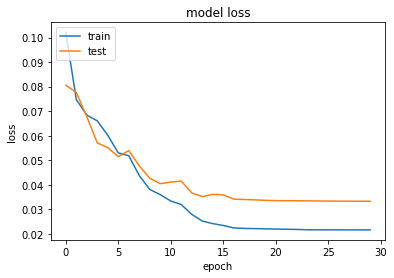

In [11]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

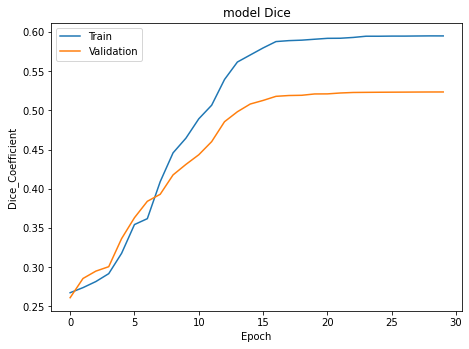

In [12]:
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model Dice')
plt.ylabel('Dice_Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [13]:
def vol_pred(case_path):
    files = next(os.walk(case_path))[2]
    X = np.empty((100, 128, 128, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=read_image(vol_path);
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=read_image(vol_path);   

    
    for j in range(100):
         X[j,:,:,0] = cv.resize(flair[:,:,j+22], (128,128))
         X[j,:,:,1] = cv.resize(ce[:,:,j+22], (128,128))
    return model.predict(X/np.max(X), verbose=1)


case = '050'
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = read_image(os.path.join(path, f'BraTS20_Training_{case}_seg.nii'))
p = vol_pred(path)

4/4 [==============================] - 1s 101ms/step


<Figure size 432x288 with 0 Axes>

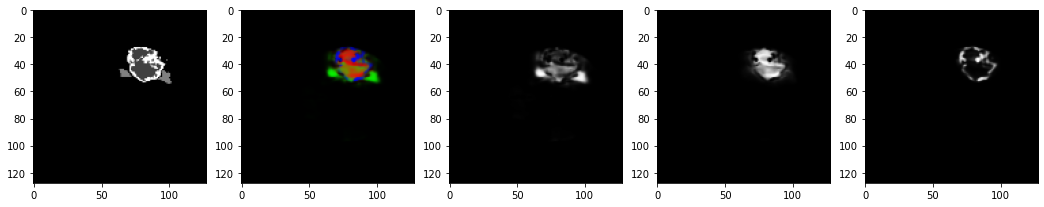

In [14]:

#p[p >= 0.4] = 1
#p[p <0.4] = 0

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


s = 40
plt.figure()
f, axarr = plt.subplots(1,5, figsize = (18, 50)) 

axarr[0].imshow(cv.resize(gt[:,:,s+22], (128, 128)), cmap="gray")
axarr[1].imshow(p[s,:,:,1:4], cmap="gray")
axarr[2].imshow(edema[s], cmap="gray")
axarr[3].imshow(core[s], cmap="gray")
axarr[4].imshow(enhancing[s], cmap="gray")


In [19]:
model.save_weights('weights.h5')